# Project 2 Part A

## Dataset information

This dataset provides ground-truth class labels to evaluate performance of multi-instance learning models on both instance-level and bag-level label predictions. DeliciousMIL was first used to evaluate performance of MLTM, a multi-label multi-instance learning method, for document classification and sentence labeling.

Multi-instance learning is a special class of weakly supervised machine learning methods where the learner receives a collection of labeled bags each containing multiple instances. A bag is set to have a particular class label if and only if at least one of its instances has that class label.

DeliciousMIL consists of a subset of tagged web pages from the social bookmarking site delicious.com. The original web pages were obtained from DeliciousT140 dataset, which was collected from the delicious.com in June 2008. Users of the website delicious.com bookmarked each page with word tags. From this dataset, we extracted text parts of each web page and chose 20 common tags as class labels. These class labels are:
reference, design, programming, internet, computer, web, java, writing, English, grammar, style, language, books, education, philosophy, politics, religion, science, history, and culture.

We randomly selected 12234 pages and randomly divided them into 8251 training and 3983 test documents. We also applied Porter stemming and standard stopword removal.

Each text document is a bag within a multi-instance learning framework consisting of multiple sentences (instances). The goal is to predict document-level and sentence-level class labels on the test set using a model which is trained given only the document-level class labels in the training set.
To evaluate performance of such a model, we have manually labeled 1468 randomly selected sentences from the test documents.

## Loading Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,hamming_loss,make_scorer,recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
import sys
import time
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import scipy.stats as sp
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.multioutput import MultiOutputClassifier


import warnings
warnings.filterwarnings("ignore")
%run ./utils.py

In [3]:
X_train, y_train, X_test, y_test, word_index = load_dataset(ngram_range=1, maxlen=200)

Loading data...
8251 train sequences
3983 test sequences
X_train shape: (8251, 200)
X_test shape: (3983, 200)


### Plot the label distribution histogram

In [4]:
labels = ['programming','style','reference','java','web','internet','culture',
'design','education','language','books','writing','computer','english','politics','history','philosophy',
'science','religion','grammar']

(-0.5, 799.5, 399.5, -0.5)

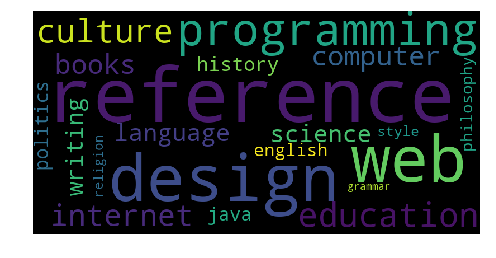

In [5]:
test = np.transpose(y_train)
cumsum = np.sum(test,axis=1)

labelsdict = {labels[i]:cumsum[i] for i in range(len(labels))}
cloud = WordCloud(width=800, height=400).generate_from_frequencies(labelsdict)
plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.axis('off')




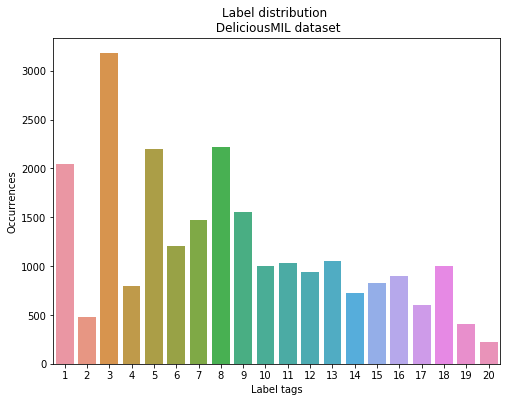

In [6]:
ind = np.arange(1, len(labels)+1)
plt.figure(figsize=(8,6))
sns.barplot(ind,cumsum)
plt.xlabel('Label tags')
plt.ylabel('Occurrences')
plt.title("Label distribution \n DeliciousMIL dataset")
plt.show()

In [7]:
# Display distribution of tags
for key,value in zip(labelsdict.keys(),labelsdict.values()):
    print('Tag : %s ,Frequency : %.f' %(key,value))

Tag : programming ,Frequency : 2050
Tag : style ,Frequency : 479
Tag : reference ,Frequency : 3181
Tag : java ,Frequency : 799
Tag : web ,Frequency : 2203
Tag : internet ,Frequency : 1211
Tag : culture ,Frequency : 1471
Tag : design ,Frequency : 2221
Tag : education ,Frequency : 1559
Tag : language ,Frequency : 1004
Tag : books ,Frequency : 1034
Tag : writing ,Frequency : 939
Tag : computer ,Frequency : 1049
Tag : english ,Frequency : 725
Tag : politics ,Frequency : 830
Tag : history ,Frequency : 898
Tag : philosophy ,Frequency : 598
Tag : science ,Frequency : 1001
Tag : religion ,Frequency : 411
Tag : grammar ,Frequency : 224


# Applying Methods

We need to pass our classifiers in an Multioutput wrapper in order to be able to make the random search

The multioutput strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification

### Define Classifiers and Scoring

In [12]:
scoring = {'Hamming Loss':make_scorer(hamming_loss),'Hamming Score':make_scorer(hamming_score),
          'Accuracy':make_scorer(accuracy_score)}

classifiers = {"Logistic Regression": MultiOutputClassifier(LogisticRegression(solver='lbfgs'),n_jobs=-1),
               "Decision Tree Classifier": MultiOutputClassifier(DecisionTreeClassifier(),n_jobs=-1),
               "NaiveBayes": MultiOutputClassifier(GaussianNB(),n_jobs=-1)}

### Random Search for finding hyperparameters


In [8]:
r = np.random.uniform(-2,2,size = 5)
C = np.array(10**r)
var_exp  = np.random.uniform(-2,-9,size=4)
var_smooth = np.array(10**var_exp)


params_tree = {'estimator__max_depth': sp.randint(1, 30),
              'estimator__max_features': sp.randint(1, X_train.shape[1]),
              'estimator__min_samples_split': sp.randint(2, X_train.shape[0] / 3),
              'estimator__criterion': ['gini', 'entropy']}
params_lgr = {'estimator__C':C}
params_nb = {'estimator__var_smoothing':var_smooth}

params = [params_lgr,params_tree,params_nb]

In [9]:
#Results
res = {}
for keys, classifier ,par in zip(classifiers.keys(),classifiers.values(),params):
    res[keys] = hyperparameters(classifier,par,X_train,y_train,'Hamming Loss',scoring,keys,random_search=True)



Εstimator : Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   42.7s finished


Best parameters found for Estimator : Logistic Regression
{'estimator__C': 25.480307991766196}

Best score found for Hamming Loss Score metric : 0.149

Εstimator : Decision Tree Classifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


Best parameters found for Estimator : Decision Tree Classifier
{'estimator__criterion': 'entropy', 'estimator__max_depth': 25, 'estimator__max_features': 173, 'estimator__min_samples_split': 61}

Best score found for Hamming Loss Score metric : 0.188

Εstimator : NaiveBayes
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.5s finished


Best parameters found for Estimator : NaiveBayes
{'estimator__var_smoothing': 7.41211858215458e-05}

Best score found for Hamming Loss Score metric : 0.431


### Grid Search for finding best hyperparameters

In [13]:
params_tree_grid = {'estimator__max_depth': [24,26,27,28],
              'estimator__max_features': [172,173,175],
              'estimator__min_samples_split': [60,62,65],
              'estimator__criterion': ['entropy']}

params_lgr_grid = {'estimator__C':[25.40,26,26.6,27]}

params_nb_grid = {'estimator__var_smoothing':[6e-5,7.5e-5,8e-5,1e-4]}

params_grid = [params_lgr_grid,params_tree_grid,params_nb_grid]

In [14]:
res = {}
for keys, classifier ,par in zip(classifiers.keys(),classifiers.values(),params_grid):
    res[keys] = hyperparameters(classifier,par,X_train,y_train,'Hamming Loss',scoring,keys,random_search=False)


Εstimator : Logistic Regression
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   27.3s finished


Best parameters found for Estimator : Logistic Regression
{'estimator__C': 25.4}

Best score found for Hamming Loss Score metric : 0.149

Εstimator : Decision Tree Classifier
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 15.8min finished


Best parameters found for Estimator : Decision Tree Classifier
{'estimator__criterion': 'entropy', 'estimator__max_depth': 28, 'estimator__max_features': 175, 'estimator__min_samples_split': 62}

Best score found for Hamming Loss Score metric : 0.190

Εstimator : NaiveBayes
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   21.5s finished


Best parameters found for Estimator : NaiveBayes
{'estimator__var_smoothing': 6e-05}

Best score found for Hamming Loss Score metric : 0.428


### Setting hyperparameters in our models

In [17]:
base_lr = LogisticRegression(solver='lbfgs',C=25.4)
base_dt = DecisionTreeClassifier(max_depth=28,max_features=175,min_samples_split=62)
base_nb = GaussianNB(var_smoothing=6e-5)
clfs = [base_lr,base_dt,base_nb]

### Classifier Chains

In [23]:
chains = {'Chain ' +str(clf):ClassifierChain(clf, order='random', random_state=i) for clf,i in zip(clfs,range(10))} 

In [18]:
preds = {}
pred_ens = {}
metrics = {}
for key,values in zip(chains.keys(),chains.values()):
    print('Fitting Chain %s' %key)
    chain.fit(X_train, y_train)
    
    preds[key] = np.array([chain.predict(X_test) for chain in
                              chains])

    pred_ens[key] = preds[key].mean(axis=0)
    ensemble_hamming_loss = hamming_loss(y_test,
                                           Y_pred_ensemble)

    chain_hamming_loss = [hamming_loss(y_test, Y_pred_chain) for Y_pred_chain in Y_pred_chains]

    model_scores = chain_hamming_loss.append(ensemble_hamming_loss)

In [19]:
model_names = ('Indepedent','Chain 1','Chain 2','Chain 3','Chain 4','Chain 5','Chain 6',
               'Chain 7','Chain 8','Chain 9','Chain 10','Ensemble')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

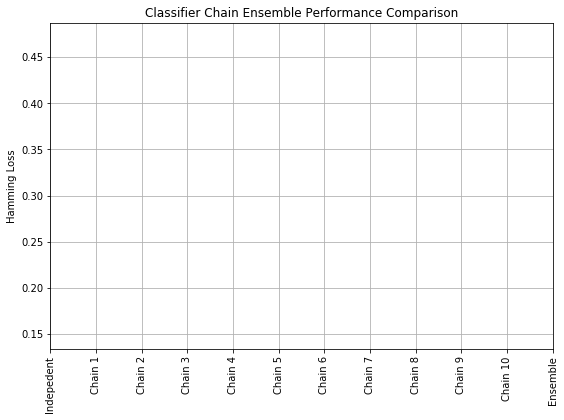

In [20]:
x_pos = np.arange(len(model_names))

# Plot the Hamming Loss for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(9, 6))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Hamming Loss')
ax.set_ylim([min(chain_hamming_loss) * .9, max(chain_hamming_loss) * 1.1])
colors =  ['b'] * (len(model_names)-1) + ['g']
ax.bar(x_pos, chain_hamming_loss, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

### RAkEL

In [39]:
classifier = RakelD(base_classifier=GaussianNB(),base_classifier_require_dense=[True, True],labelset_size=4)

classifier.fit(X_train, y_train)
prediction = classifier.predict(X_train, y_train)

NameError: name 'RakelD' is not defined

### Label Powersets